Initialization step for Google Colab

In [ ]:
# Installation cell
%%shell
if ! command -v julia 3>&1 > /dev/null
then
    wget 'https://julialang-s3.julialang.org/bin/linux/x64/1.3/julia-1.3.1-linux-x86_64.tar.gz' \
        -O /tmp/julia.tar.gz
    tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
    rm /tmp/julia.tar.gz
fi
julia -e 'using Pkg; pkg"add IJulia; precompile;"'
echo 'Done'

After you run the first cell (the the cell directly above this text), go to Colab's Edit menu and select Notebook settings from the drop down. Select Julia 1.3 as the runtime.

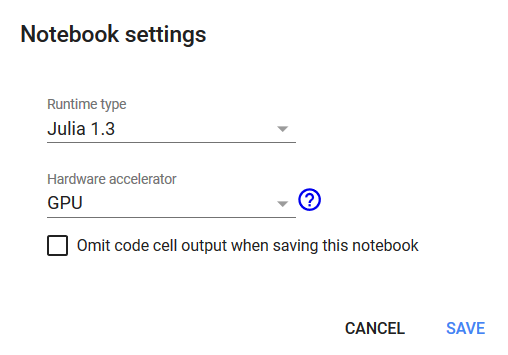

# Description of the problem:


![trebuchet](https://fluxml.ai/assets/2019-03-05-dp-vs-rl/trebuchet-basic.gif)

There is Trebuchet, which throws a mass to a target. The mass is to be
released at an angle, and at certain velocity so that it lands on the target.
The velocity of release is determined by the counterweight of the Trebuchet.
Given conditions of environment we are required to predict the angle of
release and counterweight.

* **Input:**  Wind speed,   Target distance
* **Output:** ReleaseAngle, Weight

![overview](https://fluxml.ai/assets/2019-03-05-dp-vs-rl/trebuchet-flow.png)

In [1]:
using Flux, Trebuchet
using Zygote: forwarddiff
using Statistics: mean
using Random

# linear interpolation helper
lerp(x, lo, hi) = x*(hi-lo)+lo

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-1662232092954214940\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-13299006467001319843\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-1662232092954214940\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

lerp (generic function with 1 method)

## Create Model

In [2]:
Random.seed!(0)
model = Chain(Dense(2, 16, σ),
              Dense(16, 64, σ),
              Dense(64, 16, σ),
              Dense(16, 2)) |> f64
θ = params(model)

Params([[0.3168043792247772 -0.4116273820400238; 0.47479915618896484 -0.13068382441997528; … ; 0.03846823051571846 0.4681353271007538; 0.46887311339378357 -0.3220793306827545], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.05972081050276756 0.21486465632915497 … -0.2639364004135132 -0.07606439292430878; 0.10669917613267899 0.03548042103648186 … -0.16236916184425354 0.15217024087905884; … ; 0.257627934217453 0.24063166975975037 … 0.09960717707872391 -0.13336718082427979; 0.239832803606987 -0.01261446624994278 … 0.062869593501091 -0.13437746465206146], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.04914931580424309 0.23821789026260376 … 0.16744229197502136 -0.07608868181705475; 0.02194792777299881 0.16212758421897888 … -0.10771181434392929 -0.09736878424882889; … ; -0.04913253337144852 -0.038270484656095505 … -0.08832470327615738 -0.2596207559108734; -0.10204915702342987 -0.26554459333419

## Create Loss

As Trebuchet.shoot uses `try`/`catch` within, which is not yet supported by default backwards differentiation, we need to mark our shoot function with ``Zygote.forwarddiff`` marker.

In [11]:
function _shoot(wind, angle, weight)
  Trebuchet.shoot((wind, Trebuchet.deg2rad(angle), weight))[2]
end

shoot(wind, angle, weight) = forwarddiff(args -> shoot(args...), [wind, angle, weight])

shoot (generic function with 2 methods)

In [6]:
function aim(wind, target)
  angle, weight = model([wind, target])
  angle = σ(angle)*90
  weight = weight + 200
  angle, weight
end

distance(wind, target) = shoot(wind, aim(wind, target)...)

function loss(wind, target)
    (distance(wind, target) - target)^2
end

loss (generic function with 1 method)

## Train

In [8]:
DIST  = (20, 100)	# Maximum target distance
SPEED =   5 # Maximum wind speed

target() = (randn() * SPEED, lerp(rand(), DIST...))
dataset = (target() for i = 1:100_000)

Base.Generator{UnitRange{Int64},var"#7#8"}(var"#7#8"(), 1:100000)

In [10]:
opt = ADAM()

meanloss() = mean(sqrt(loss(target()...)) for i = 1:100)
cb = Flux.throttle(() -> @show(meanloss()), 10)

Flux.train!(loss, θ, dataset, opt, cb = cb)

meanloss() = 27.453721987356246
meanloss() = 4.112434513188521
meanloss() = 4.6740403729001185
meanloss() = 2.503849002993281
meanloss() = 3.7323880002003293
meanloss() = 3.1933209171762225
meanloss() = 2.6113425638767818
meanloss() = 2.617652736285628
meanloss() = 1.9170700207077482
meanloss() = 2.1478119836351617
meanloss() = 3.138349903043968
meanloss() = 3.799919755604677
meanloss() = 2.0791362684310464
meanloss() = 1.7607045610898524
meanloss() = 1.8669339271242746
meanloss() = 2.4895898754412293
meanloss() = 3.24084496347228
meanloss() = 2.2180810300848033
meanloss() = 2.1001847338137334
meanloss() = 2.8730234625593365
meanloss() = 3.6226565205903296
meanloss() = 2.6446318756822507
meanloss() = 2.5674407543594646
meanloss() = 2.330216910809488
meanloss() = 2.5637590299677413
meanloss() = 2.323357035356098
meanloss() = 1.435861802748482
meanloss() = 3.554102147474416
meanloss() = 2.4212462143622613
meanloss() = 1.467099328656713
meanloss() = 3.1329125062189846
meanloss() = 2.02068

# Thank you

For more details and further examples see the original blogpost  https://fluxml.ai/2019/03/05/dp-vs-rl.html.